In [45]:
import sys
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

import hw5_part1 as hw5

In [46]:
mnist_global_mean = 0.1307
mnist_global_stdev = 0.3081

device = hw5.get_device()
model = hw5.NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

Using mps device


<All keys matched successfully>

In [47]:
def load_data():
  
  transformer = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mnist_global_mean,), (mnist_global_stdev,))])
  
  # Download test data from open datasets.
  test_data = datasets.MNIST(
      root="./data",
      train=False,
      download=True,
      transform=transformer,
  )
  
  subset_index = list(range(10))
  
  subset_test_data = Subset(test_data, subset_index)
  
  return DataLoader(subset_test_data, batch_size=10, shuffle=False)

In [48]:
def eval(test_dataloader):
   # enable the testing mode
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_dataloader:
            # send the data to hardware device
            data, target = data.to(device), target.to(device)
            output = model(data)
            # Compute the negative log likelihood loss
            test_loss += nn.functional.nll_loss(output, target, size_average=False).item()
            # Get the index of the maximum log-probability
            pred = output.data.max(1, keepdim=True)[1]
            # Count the number of correct predictions
            correct += pred.eq(target.data.view_as(pred)).sum()
    
    # Compute average loss        
    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)
    
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))
    return

In [44]:
subset_test_dataloader = load_data()

for X, y in subset_test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break


examples = enumerate(subset_test_dataloader)
batch_idx, (example_data, example_targets) = next(examples)

print(example_targets)

with torch.no_grad():
    example_data, example_targets = example_data.to(device), example_targets.to(device)
    output = model(example_data)
    probabilities = F.softmax(output, dim=1)
    predicted = output.data.max(1, keepdim=True)[1]
    
    top_p, top_class = probabilities.topk(1, dim = 1)
    
    # print(top_p)
    # print(top_class)
    
    for i in range(len(example_data)):
        print(f"Example {i + 1} - Correct Label: {example_targets[i]}, Predicted Label: {top_class[i].item()}, Probabilities: {top_p[i].item():.2f}")



Shape of X [N, C, H, W]: torch.Size([10, 1, 28, 28])
Shape of y: torch.Size([10]) torch.int64
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])
Example 1 - Correct Label: 7, Predicted Label: 7, Probabilities: 1.00
Example 2 - Correct Label: 2, Predicted Label: 2, Probabilities: 0.97
Example 3 - Correct Label: 1, Predicted Label: 1, Probabilities: 0.99
Example 4 - Correct Label: 0, Predicted Label: 0, Probabilities: 1.00
Example 5 - Correct Label: 4, Predicted Label: 4, Probabilities: 0.99
Example 6 - Correct Label: 1, Predicted Label: 1, Probabilities: 1.00
Example 7 - Correct Label: 4, Predicted Label: 4, Probabilities: 0.97
Example 8 - Correct Label: 9, Predicted Label: 9, Probabilities: 0.73
Example 9 - Correct Label: 5, Predicted Label: 2, Probabilities: 0.48
Example 10 - Correct Label: 9, Predicted Label: 9, Probabilities: 0.96


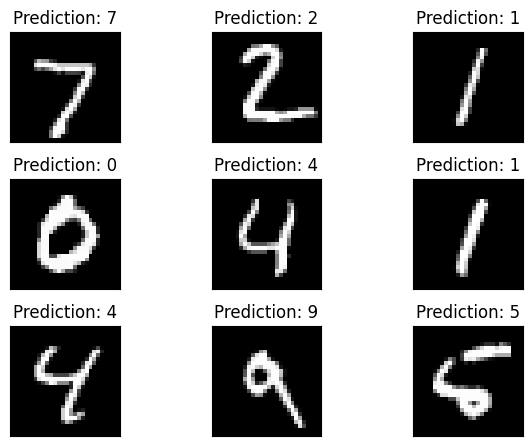

In [17]:
example_data_local = [tensor.cpu() for tensor in example_data]

fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data_local[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])

plt.show()